<a href="https://colab.research.google.com/github/fajrunwm/geog0105/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net

U-Net application for urban settlement segregation in BSD, Tangerang City, Indonesia

# Data Preparation

## Connect to Google Drive

Mounting Google Drive to access our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Essential Libraries

In [ ]:
import os  # Operating system interfaces for file handling
import numpy as np  # Numerical operations on large arrays
import tensorflow as tf  # TensorFlow for deep learning
#import random  # Generate random numbers
import matplotlib.pyplot as plt  # Plotting and visualization

from PIL import Image
from sklearn.model_selection import train_test_split  # Splitting the dataset into training and validation sets
from tensorflow.keras.utils import to_categorical  # Convert class vectors to binary class matrices
from tensorflow.keras.utils import plot_model # For plotting the model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate  # Layers for building the U-Net model
from tensorflow.keras.models import Model  # Class to create a Keras model
from tensorflow.keras.optimizers import Adam  # Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when a monitored metric has stopped improving
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # Functions to load and process images

## Check GPU

In [ ]:
# Check for available GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f'GPU found: {physical_devices}')
    # Set memory growth to avoid memory allocation issues
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print('No GPU found.')

GPU found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loading

In [ ]:
# Function to load images and masks from directories
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = load_img(img_path, target_size=target_size)
        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")

        img = img_to_array(img) / 255.0  # Normalize image
        mask = img_to_array(mask)  # Do not normalize mask for discrete class values

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
# Defining the image, mask, and label directories
image_dir = 'drive/MyDrive/Colab Notebooks/GEOG0105/ML_UIS/dataset_v5/images'
mask_dir = 'drive/MyDrive/Colab Notebooks/GEOG0105/ML_UIS/dataset_v5/masks'
images, masks = load_images_and_masks(image_dir, mask_dir)

In [ ]:
# Verify the lengths of images and masks
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

Number of images: 135
Number of masks: 135


In [ ]:
# Verify File Existence (optional)
# List files in directories
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

# Print out the lists of files
print("Image files:", image_files)
print()
print("Mask files:", mask_files)

Image files: ['for10_patch_0_3.tif', 'for10_patch_2_8.tif', 'for10_patch_8_7.tif', 'for14_patch_6_9.tif', 'for14_patch_2_6.tif', 'for15_patch_0_8.tif', 'for15_patch_4_9.tif', 'for14_patch_8_9.tif', 'for15_patch_8_2.tif', 'for22_patch_0_9.tif', 'for22_patch_3_18.tif', 'for22_patch_6_2.tif', 'for24_patch_1_9.tif', 'for24_patch_4_7.tif', 'for24_patch_7_4.tif', 'for28_patch_2_14.tif', 'for28_patch_0_0.tif', 'for28_patch_6_9.tif', 'for29_patch_8_0.tif', 'for29_patch_3_9.tif', 'for29_patch_3_2.tif', 'for40_patch_2_15.tif', 'for40_patch_4_6.tif', 'for40_patch_7_8.tif', 'for44r_patch_2_7.tif', 'for44r_patch_1_11.tif', 'for5-18_patch_2_0.tif', 'for44r_patch_6_8.tif', 'for5-18_patch_0_1.tif', 'for5-18_patch_6_4.tif', 'for5-18_patch_8_6.tif', 'for5-18_patch_5_3.tif', 'for5-18_patch_9_0.tif', 'inf-for12_patch_8_2.tif', 'inf-for12_patch_5_9.tif', 'inf-for12_patch_9_9.tif', 'inf-for30_patch_4_6.tif', 'inf-for30_patch_6_9.tif', 'inf-for30_patch_6_7.tif', 'inf-for34_patch_7_11.tif', 'inf-for34_patch_5

## Check the Mask Values

In [ ]:
# Iterate through all files in the directory
for filename in os.listdir(mask_dir):
    if filename.endswith('.png'):
        label_png = os.path.join(mask_dir, filename)
        lbl = np.asarray(Image.open(label_png))

        # Print information about the current mask image
        print(f'------------------------------------')
        print(f"Processing file: {filename}")
        #print(f"Data type: {lbl.dtype}")
        print(f"Unique values: {np.unique(lbl)}")
        #print(f"Shape: {lbl.shape}\n")

------------------------------------
Processing file: mask_inf3_patch_3_9.png
Unique values: [0 2]
------------------------------------
Processing file: mask_inf7_patch_7_11.png
Unique values: [0 2]
------------------------------------
Processing file: mask_inf27_patch_5_14.png
Unique values: [0 2]
------------------------------------
Processing file: mask_inf19_patch_7_7.png
Unique values: [0 2]
------------------------------------
Processing file: mask_inf-for45_patch_6_8.png
Unique values: [0 1]
------------------------------------
Processing file: mask_inf25-36_patch_2_3.png
Unique values: [0 2]
------------------------------------
Processing file: mask_for5-18_patch_9_0.png
Unique values: [0 1]
------------------------------------
Processing file: mask_inf31-32_patch_5_9.png
Unique values: [0 2]
------------------------------------
Processing file: mask_inf37_patch_3_7.png
Unique values: [0 2]
------------------------------------
Processing file: mask_inf-for45_patch_8_12.png
Uniq

## Debug Unique Classes in Masks

In [ ]:
# Check unique values in masks and shape of masks
unique_values = np.unique(masks)
print("Unique values in masks:", unique_values)
print("Shape of masks array:", masks.shape)

# Ensure unique values in masks do not exceed the number of classes
n_classes = len(unique_values)
print("Number of classes:", n_classes)

Unique values in masks: [0. 1. 2.]
Shape of masks array: (135, 256, 256, 1)
Number of classes: 3


In [ ]:
# Determine Number of Unique Classes
masks_cat = to_categorical(masks, num_classes=n_classes)

## Optionally split into train/validation/test sets
x_train, x_val, y_train, y_val = train_test_split(images,
                                                  masks_cat,
                                                  test_size=0.2, # adjust between 0.2 to 0.3
                                                  random_state=42) # adjust but mostly 42

# U-Net Architecture

## Model Building

In [ ]:
# Function to build U-Net model
def unet_model(input_size=(256, 256, 3), num_classes=3):
    inputs = Input(input_size)

    # Down-sampling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Up-sampling path
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    output_layer = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[output_layer])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', iou])

    return model

## IoU Metric

In [ ]:
# Function to calculate Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), dtype=tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), dtype=tf.float32)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection

    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score

## Plot the Model Architecture

In [ ]:
# Define dice_loss
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

In [ ]:
# Define jaccard_loss
def jaccard_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1)

In [ ]:
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.0001), # adjust for better result (0.00001 to 0.001), the smaller the better
              loss='categorical_crossentropy',
              #loss=dice_loss,
              #loss=jaccard_loss,
              metrics=['accuracy', iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

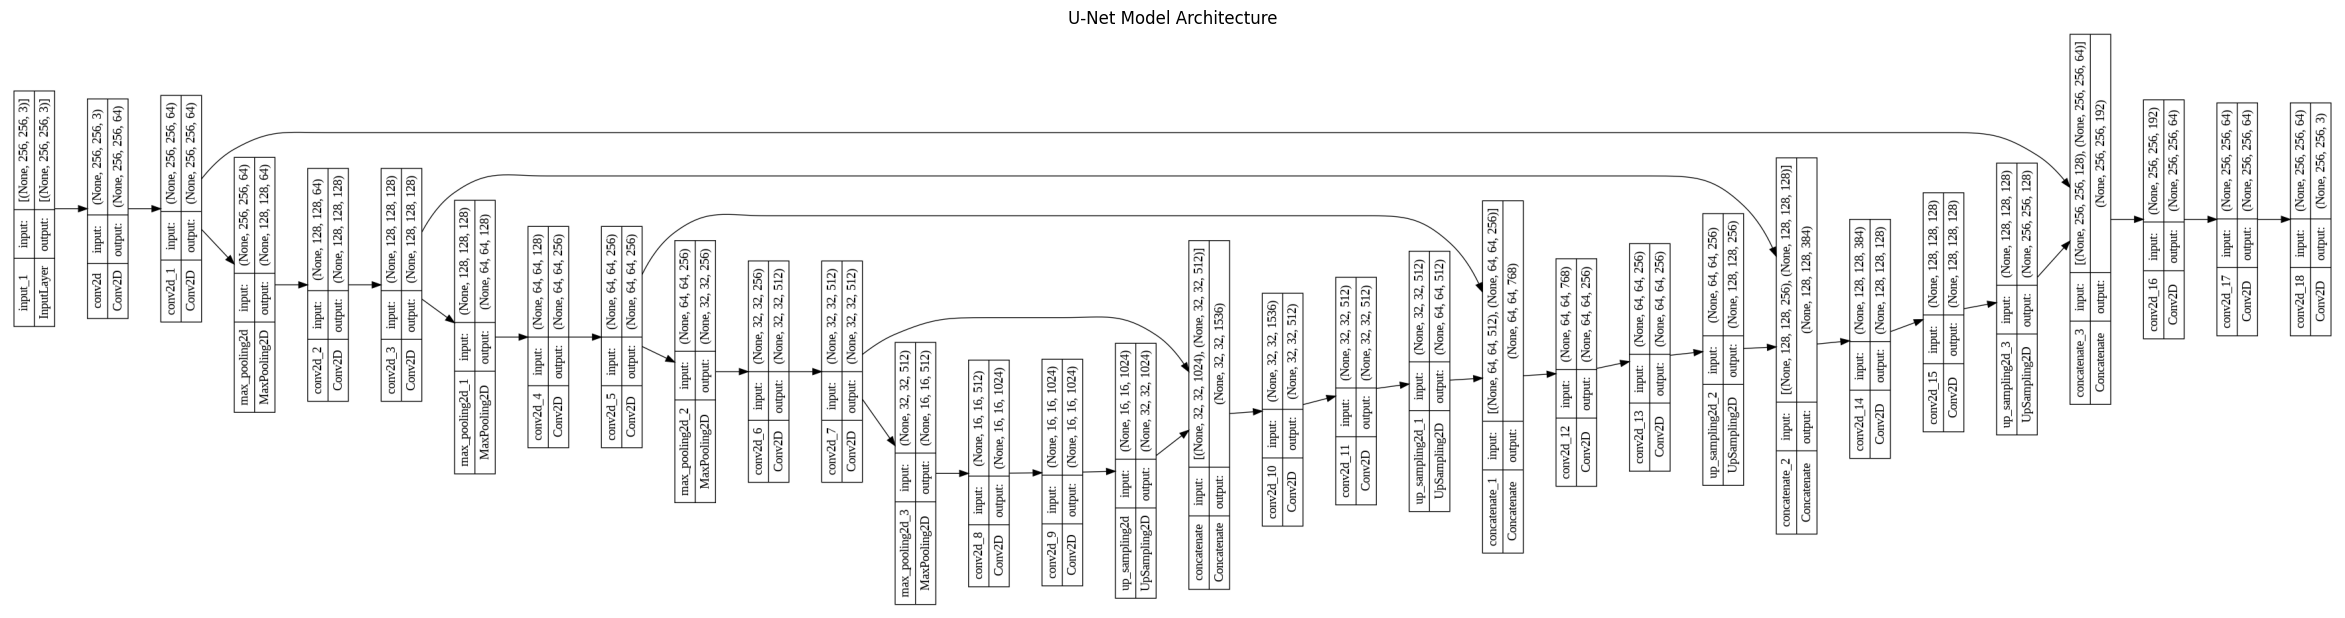

In [ ]:
plot_model(model,
           to_file='unet_model.png',
           show_shapes=True,
           show_layer_names=True)

# Load and rotate the image array
image = plt.imread('unet_model.png')
image_rotated = np.rot90(image)

# Display the rotated image
plt.figure(figsize=(30, 15))
plt.imshow(image_rotated)
plt.title('U-Net Model Architecture')
plt.axis('off')

plt.show()

## Model Training


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,  # adjust for better result (5, 10,  20), the higher can avoid overfitting
                               restore_best_weights=True)

# Data augmentation for training
datagen = ImageDataGenerator(rotation_range=20,  # adjust for better result (20, 30, 40)
                             width_shift_range=0.1,  # adjust for better result (0.1, 0.2)
                             height_shift_range=0.1,  # adjust for better result (0.1, 0.2)
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2)  # adjust for better result (0.2, 0.3)
datagen.fit(x_train)

# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=100, # adjust for better result (20, 30, ..., 100, 200), larger number can lead to better convergence and overfitting, vice versa
                    batch_size=8, # adjust for better result (4, 8, 16, 32, 64), smaller number requires more memory and longer training times, larger number requires more computational resources.
                    callbacks=[early_stopping]
                    )

# Collecting IoU values
iou_values = history.history['iou']
val_iou_values = history.history['val_iou']


Epoch 1/100
14/14 [==============================] - 54s 2s/step - loss: 1.0784 - accuracy: 0.5512 - iou: 0.2338 - val_loss: 1.0799 - val_accuracy: 0.4131 - val_iou: 0.2069
Epoch 2/100
14/14 [==============================] - 7s 471ms/step - loss: 1.0480 - accuracy: 0.5629 - iou: 0.2143 - val_loss: 1.0788 - val_accuracy: 0.4131 - val_iou: 0.2082
Epoch 3/100
14/14 [==============================] - 6s 466ms/step - loss: 0.9992 - accuracy: 0.5629 - iou: 0.2395 - val_loss: 1.1635 - val_accuracy: 0.4131 - val_iou: 0.2382
Epoch 4/100
14/14 [==============================] - 6s 460ms/step - loss: 0.9787 - accuracy: 0.5629 - iou: 0.2666 - val_loss: 1.1126 - val_accuracy: 0.4131 - val_iou: 0.2355
Epoch 5/100
14/14 [==============================] - 7s 471ms/step - loss: 0.9530 - accuracy: 0.5629 - iou: 0.2767 - val_loss: 1.0881 - val_accuracy: 0.4131 - val_iou: 0.2427
Epoch 6/100
14/14 [==============================] - 7s 476ms/step - loss: 0.9124 - accuracy: 0.5629 - iou: 0.3074 - val_loss: 

# Visualisation of Training Results

## Plot Training and Validation

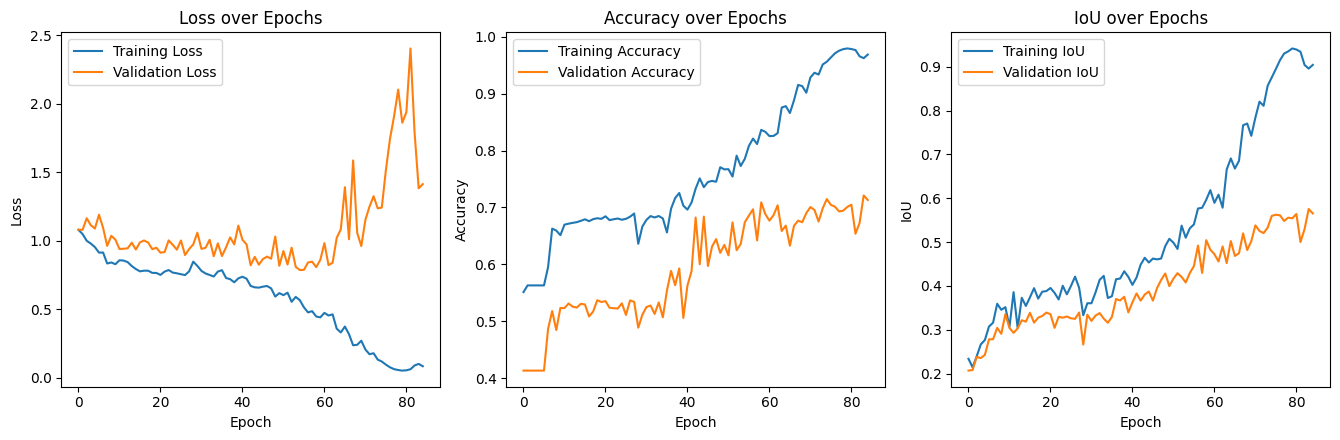

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 4.5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

ax3.plot(history.history['iou'], label='Training IoU')
ax3.plot(history.history['val_iou'], label='Validation IoU')
ax3.legend()
ax3.set_title('IoU over Epochs')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')

plt.tight_layout()
plt.show()

## Visualise Sample Predictions

1/1 [==============================] - 2s 2s/step


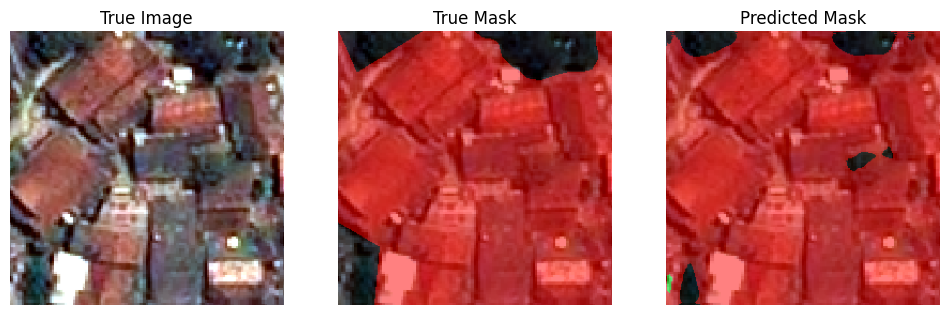

1/1 [==============================] - 0s 25ms/step


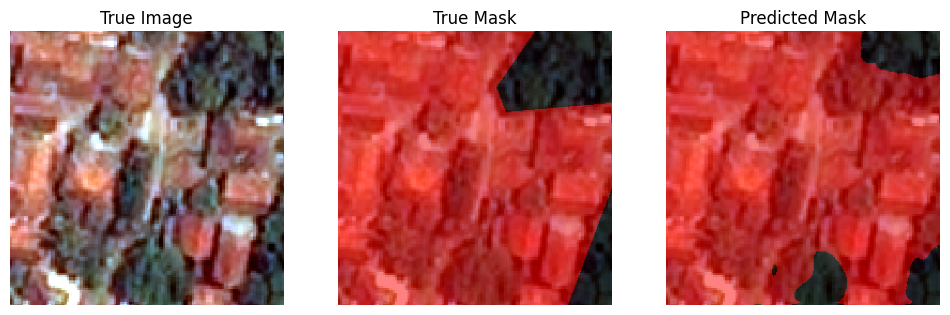

1/1 [==============================] - 0s 17ms/step


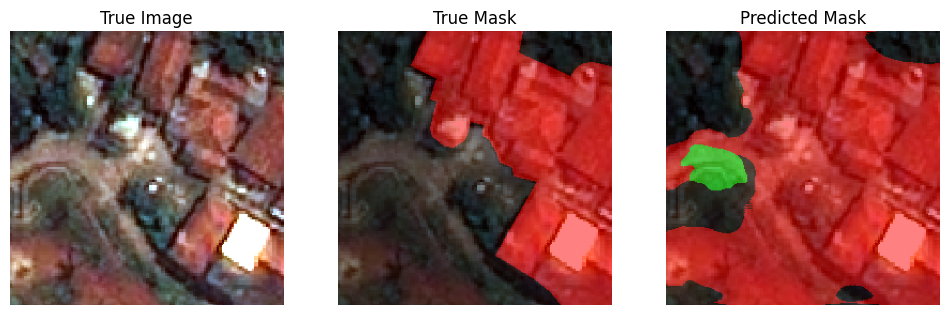

1/1 [==============================] - 0s 18ms/step


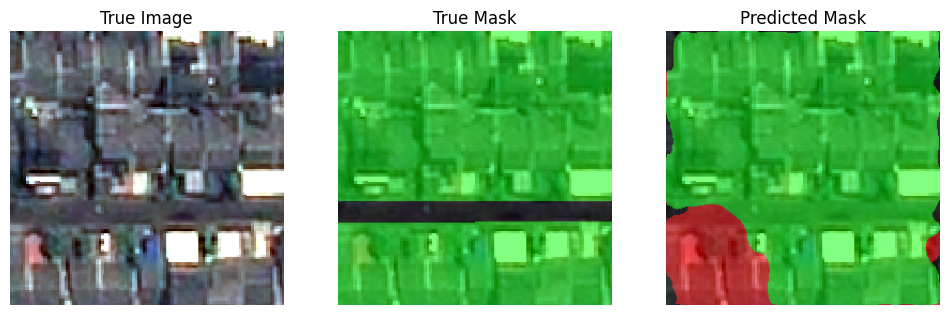

1/1 [==============================] - 0s 18ms/step


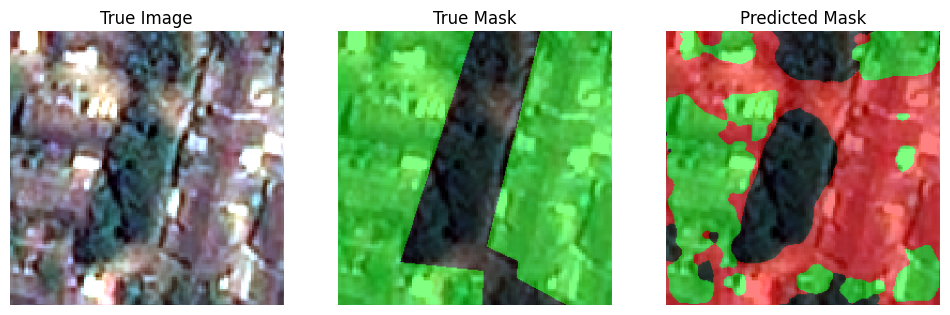

1/1 [==============================] - 0s 20ms/step


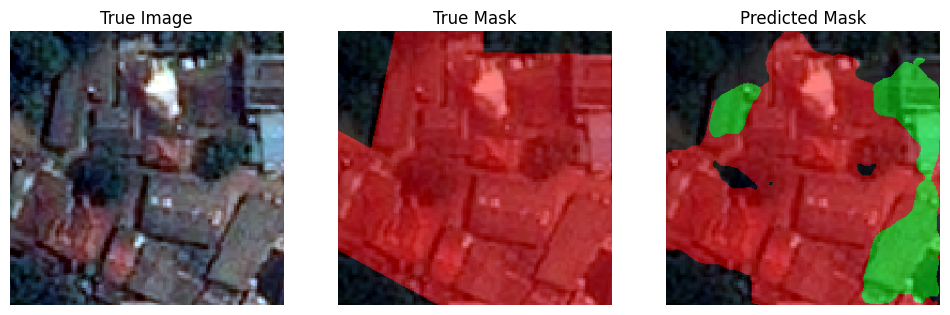

1/1 [==============================] - 0s 18ms/step


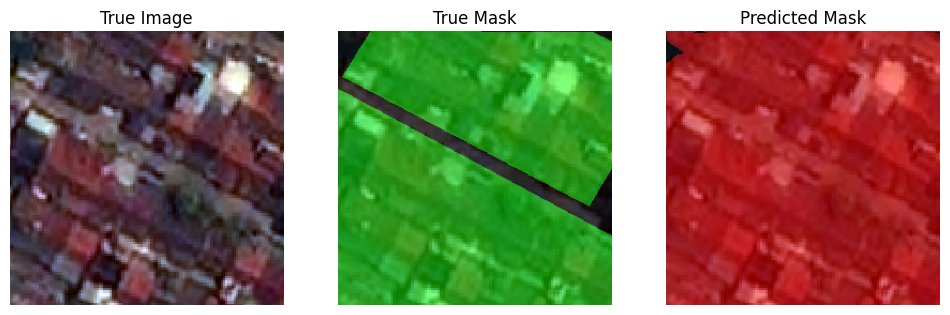

1/1 [==============================] - 0s 22ms/step


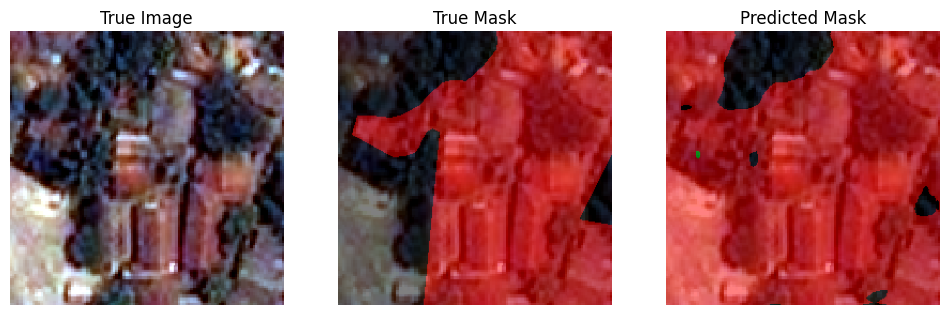

1/1 [==============================] - 0s 30ms/step


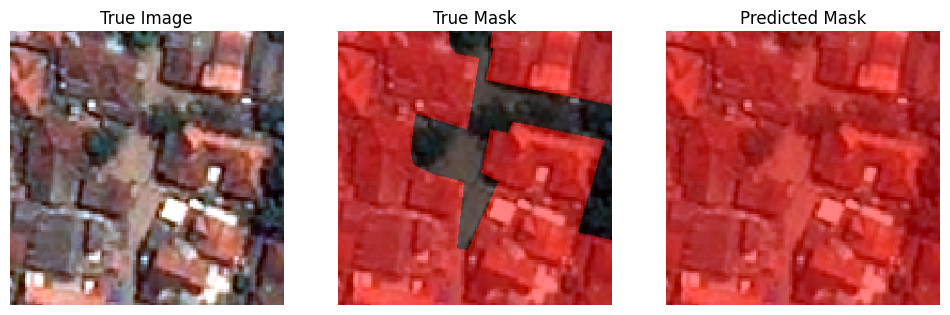

1/1 [==============================] - 0s 26ms/step


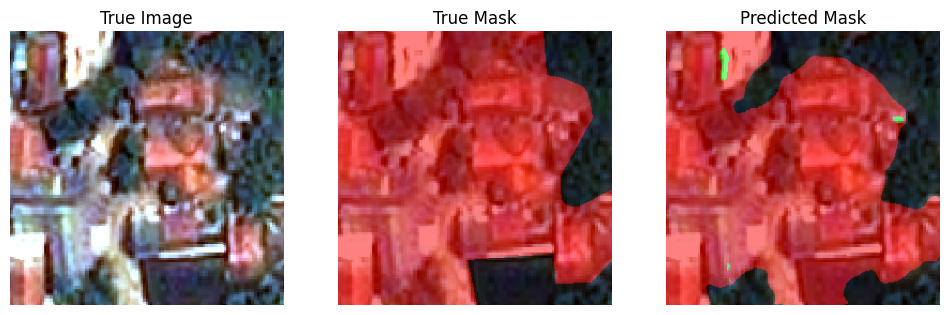

1/1 [==============================] - 0s 27ms/step


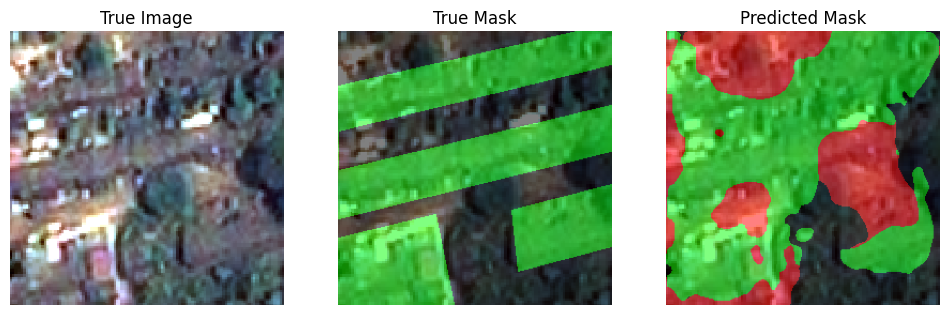

1/1 [==============================] - 0s 24ms/step


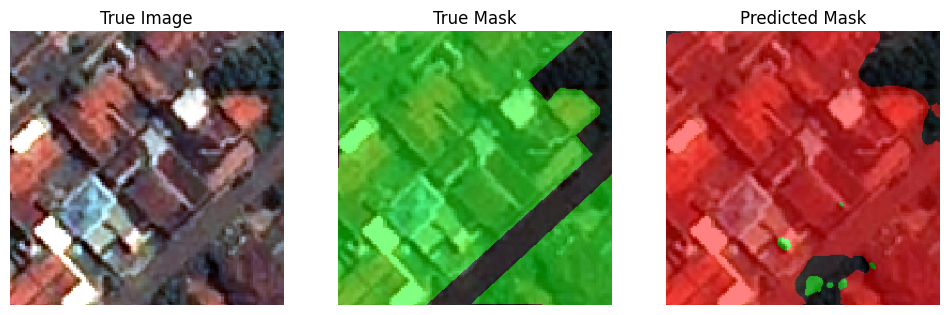

1/1 [==============================] - 0s 28ms/step


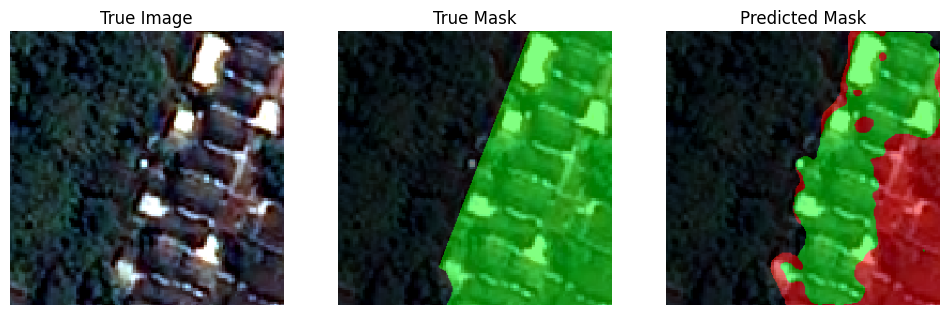

1/1 [==============================] - 0s 27ms/step


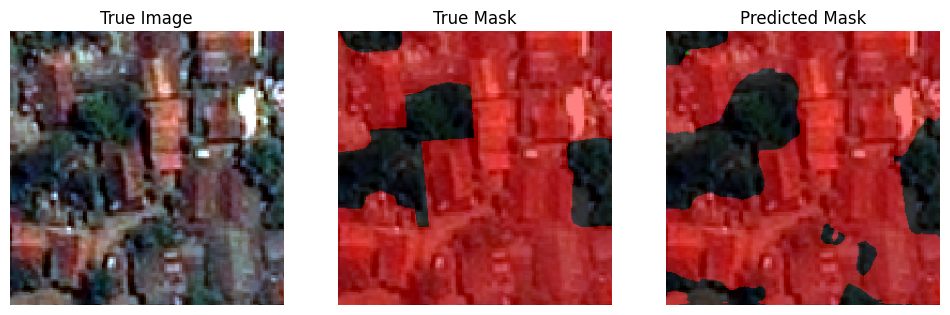

1/1 [==============================] - 0s 27ms/step


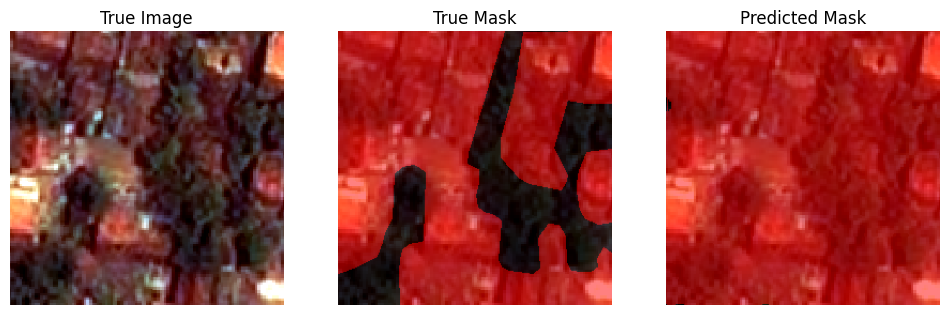

1/1 [==============================] - 0s 33ms/step


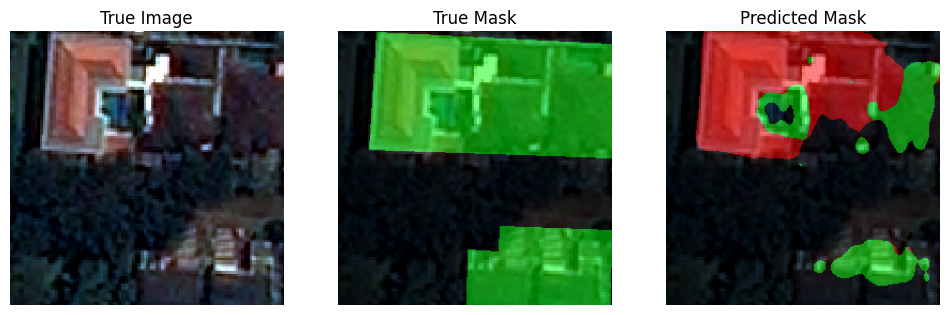

1/1 [==============================] - 0s 28ms/step


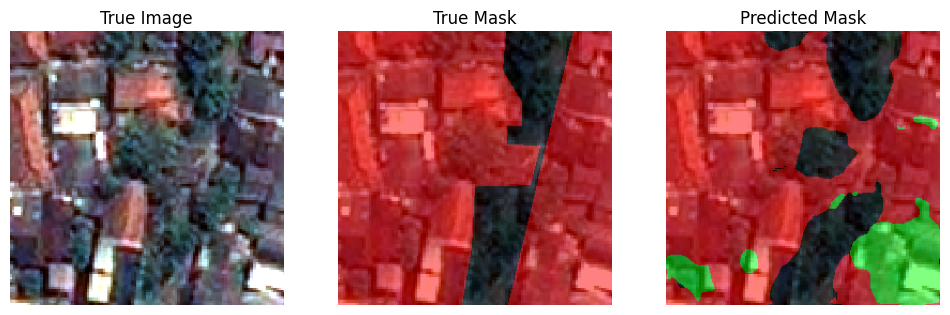

1/1 [==============================] - 0s 38ms/step


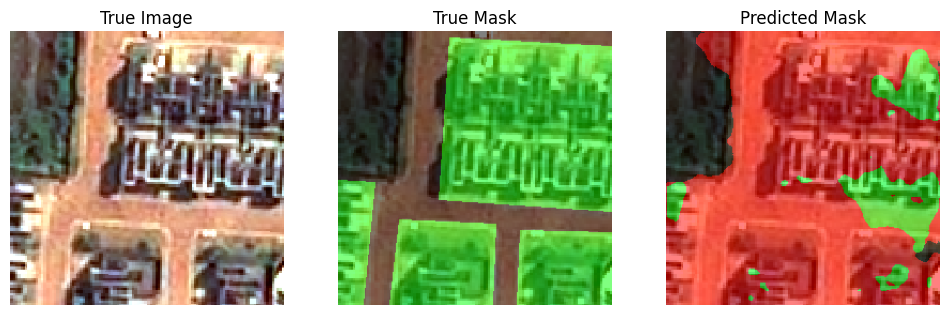

1/1 [==============================] - 0s 29ms/step


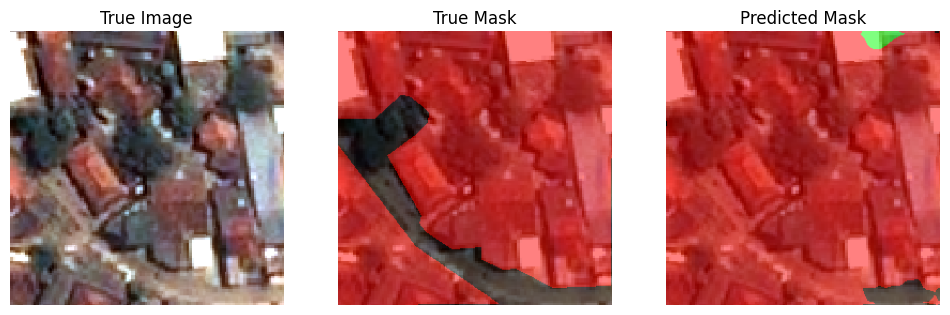

1/1 [==============================] - 0s 31ms/step


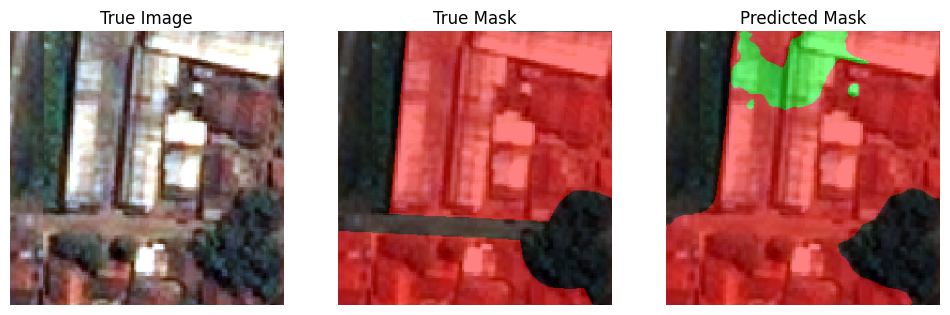

1/1 [==============================] - 0s 32ms/step


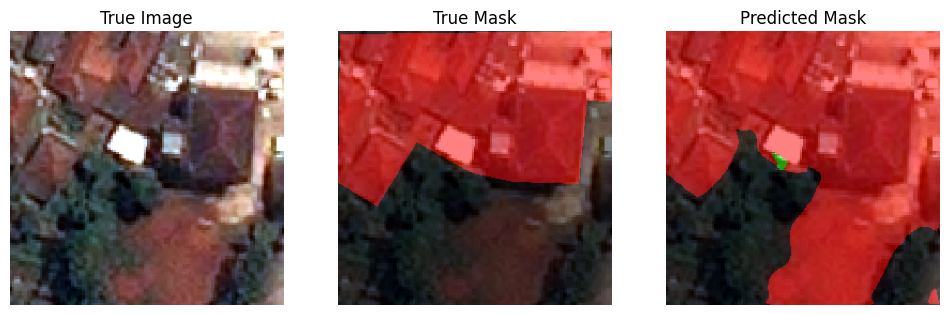

1/1 [==============================] - 0s 36ms/step


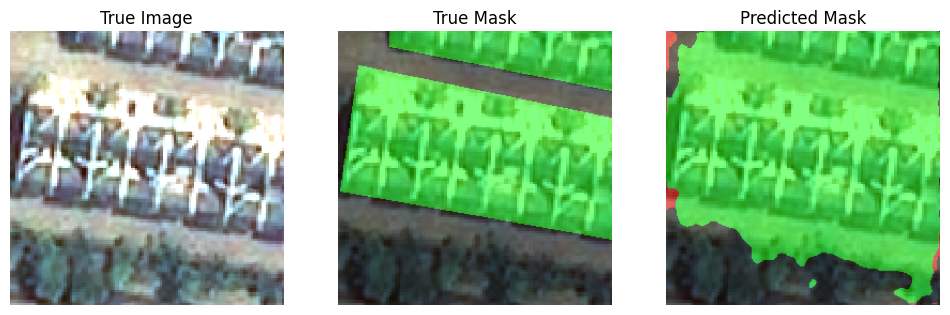

1/1 [==============================] - 0s 31ms/step


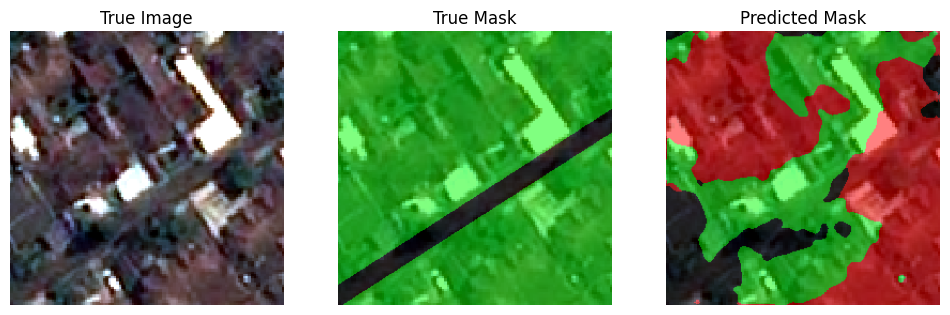

1/1 [==============================] - 0s 25ms/step


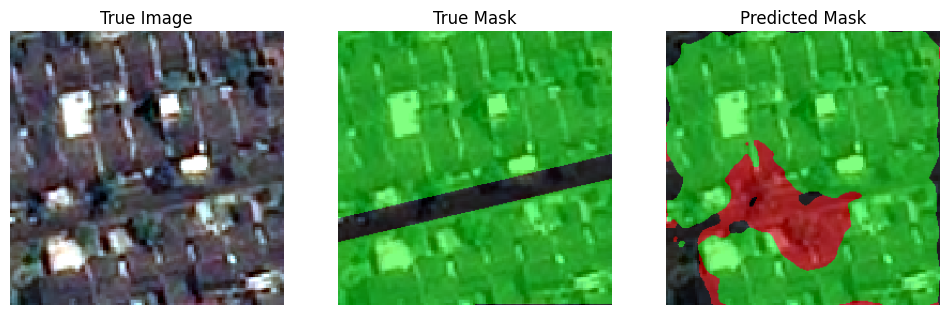

1/1 [==============================] - 0s 27ms/step


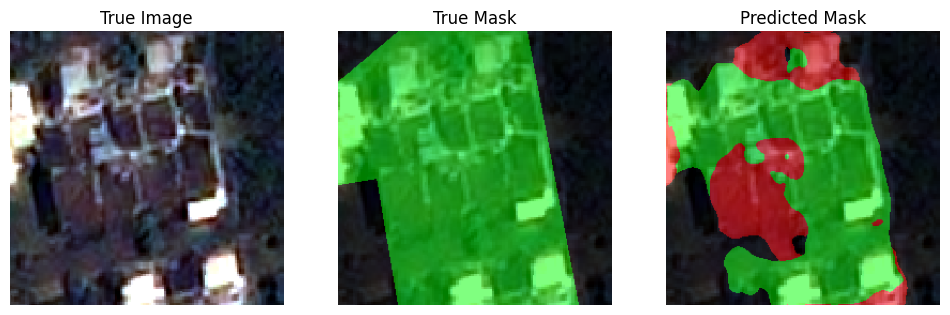

1/1 [==============================] - 0s 27ms/step


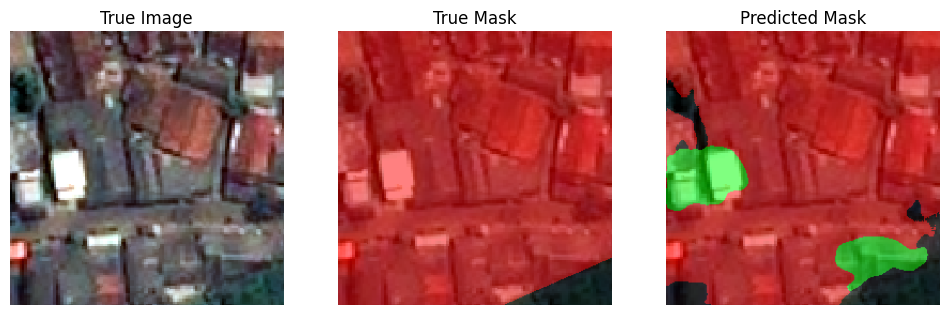

1/1 [==============================] - 0s 25ms/step


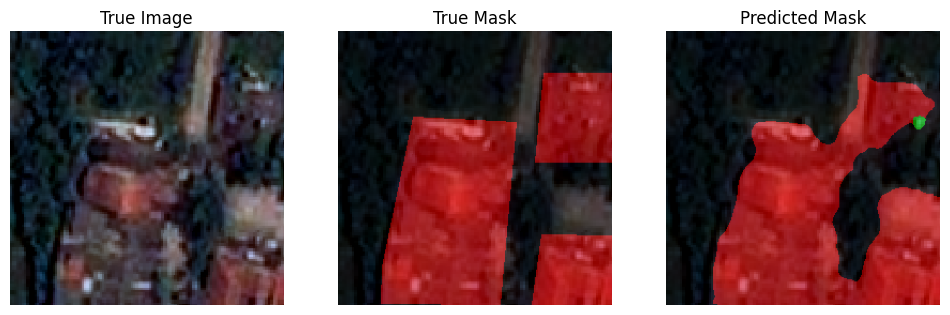

In [ ]:
# Define the label-to-color mapping
label_to_color = {
    0: (0, 0, 0),        # _background_ - Black
    1: (0, 255, 0),      # formal - Green
    2: (255, 0, 0)       # informal - Red
}

# Function to convert mask to RGB image using label-to-color mapping
def mask_to_rgb(mask):
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for label, color in label_to_color.items():
        rgb_mask[mask == label] = color
    return rgb_mask

# Plot sample predictions with color mapping
def plot_sample_predictions(model, x_val, y_val, image_files):
    num_samples = len(x_val)

    for i in range(num_samples):
        x_sample = x_val[i]
        y_true = np.argmax(y_val[i], axis=-1)
        y_pred = np.argmax(model.predict(np.expand_dims(x_sample, axis=0)), axis=-1).squeeze()

        # Get the file name for the current sample
        file_name = image_files[i]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

        ax1.imshow(x_sample)
        ax1.set_title('True Image')
        ax1.axis('off')

        ax2.imshow(x_sample)
        ax2.imshow(mask_to_rgb(y_true), alpha=0.5)
        ax2.set_title('True Mask')
        ax2.axis('off')

        ax3.imshow(x_sample)
        ax3.imshow(mask_to_rgb(y_pred), alpha=0.5)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()

# Evaluate the model (not necessary to do this in every loop iteration)
loss, accuracy, iou_score = model.evaluate(x_val, y_val)

# Assuming model, x_val, y_val, and image_files are defined
plot_sample_predictions(model, x_val, y_val, image_files)